In [1]:
import os
import numpy as np

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
from provabgs import models as Models

/Users/chahah/projects/provabgs/src/provabgs/models.py:29: UserWarning: import error with pytorch; cannot use msurv emulator
  warnings.warn('import error with pytorch; cannot use msurv emulator')


In [4]:
m_nmf = Models.NMF(emulator=True, burst=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


# load test theta and SEDs

In [5]:
dat_dir = '/Users/chahah/data/provabgs/emulator/'

wave_test = np.load(os.path.join(dat_dir, 'wave.nmf.npy'))
wlim = (wave_test > 2004)
wave_test = wave_test[wlim]

theta_test = np.load(os.path.join(dat_dir, 'fsps.nmf.v0.1.theta.test.npy'))[:,1:]
lnsed_test = np.load(os.path.join(dat_dir, 'fsps.nmf.v0.1.lnspectrum.test.npy'))[:,wlim]

In [6]:
print('%i SEDs in test set' % theta_test.shape[0])

100000 SEDs in test set


In [7]:
lnsed_pred = np.array([m_nmf._emu_nmf(theta_test[i]) for i in range(theta_test.shape[0])])

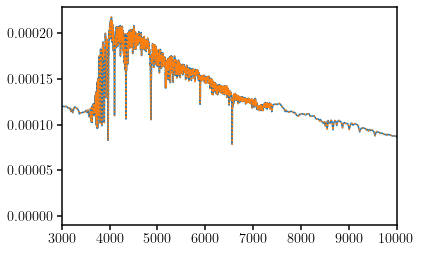

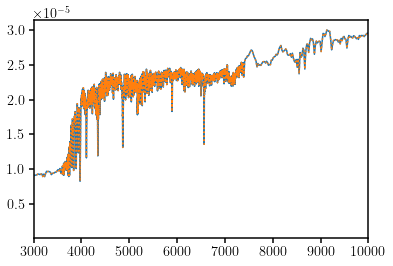

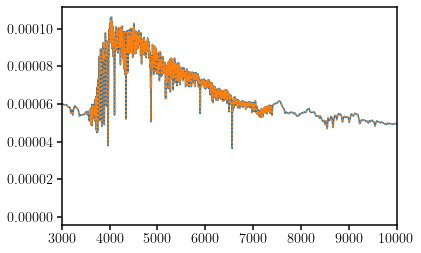

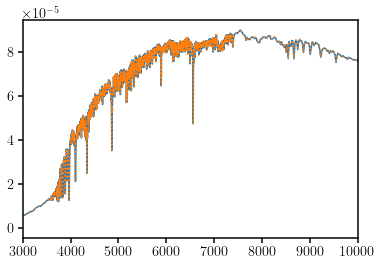

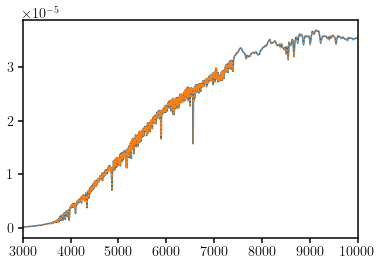

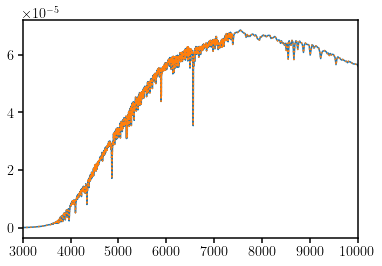

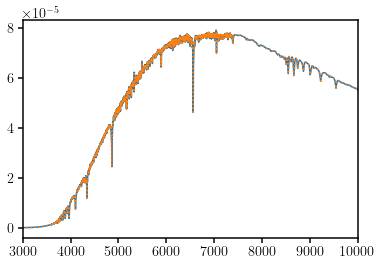

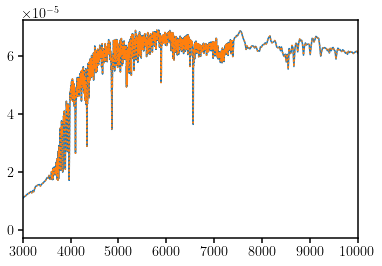

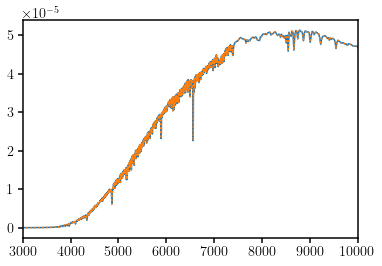

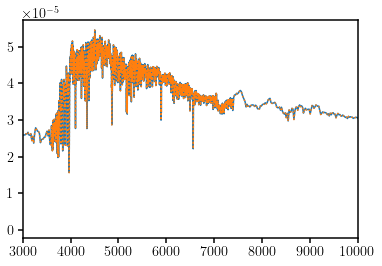

In [8]:
for i in range(10): 
    plt.plot(wave_test, np.exp(lnsed_pred[i]))
    plt.plot(wave_test, np.exp(lnsed_test[i]), ls=':')
    plt.xlim(3e3, 1e4)
    plt.show()

In [9]:
frac_dspec = 1. - np.exp(lnsed_pred - lnsed_test)
frac_dspec_quantiles = np.nanquantile(frac_dspec, [0.0005, 0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995, 0.9995], 
                                      axis=0)

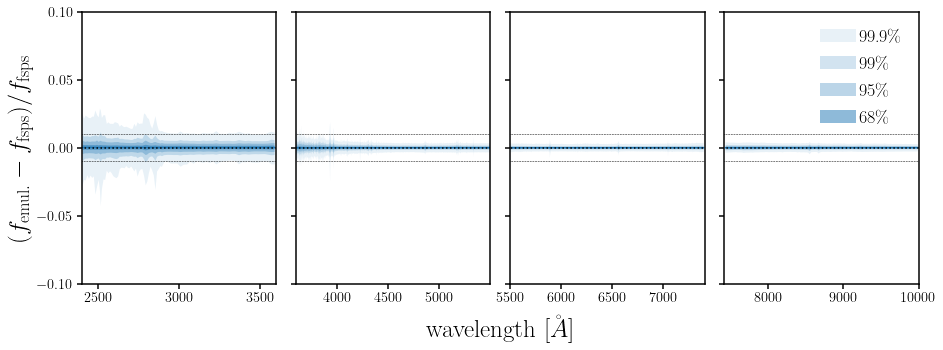

In [10]:
fig = plt.figure(figsize=(15,5))

for i_w in range(4): 
    w0 = [2400, 3600, 5500, 7410][i_w]
    w1 = [3600, 5500, 7410, 1e4][i_w]
    wbin = (wave_test > w0) & (wave_test < w1)
    _wave = wave_test[wbin]
    
    sub = fig.add_subplot(1,4,i_w+1)
    sub.fill_between(_wave, frac_dspec_quantiles[0][wbin], frac_dspec_quantiles[-1][wbin], 
            fc='C0', ec='none', alpha=0.1, label=r'99.9$\%$')
    sub.fill_between(_wave, frac_dspec_quantiles[1][wbin], frac_dspec_quantiles[-2][wbin], 
            fc='C0', ec='none', alpha=0.2, label=r'99$\%$')
    sub.fill_between(_wave, frac_dspec_quantiles[2][wbin], frac_dspec_quantiles[-3][wbin], 
            fc='C0', ec='none', alpha=0.3, label=r'95$\%$')
    sub.fill_between(_wave, frac_dspec_quantiles[3][wbin], frac_dspec_quantiles[-4][wbin],
            fc='C0', ec='none', alpha=0.5, label=r'68$\%$')
    sub.plot(_wave, frac_dspec_quantiles[4][wbin], c='C0', ls='-') 
    sub.plot([2e3, 6e4], [0., 0.], c='k', ls=':') 

    # mark +/- 1%
    sub.plot([2e3, 6e4], [0.01, 0.01], c='k', ls='--', lw=0.5)
    sub.plot([2e3, 6e4], [-0.01, -0.01], c='k', ls='--', lw=0.5)

    if i_w == 3: sub.legend(loc='upper right', fontsize=18, handletextpad=0.2)
    if i_w == 1: sub.set_xticks([4000, 4500, 5000])
    sub.set_xlim(w0, w1)
    if i_w == 0: 
        sub.set_ylabel(r'$(f_{\rm emul.} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
        sub.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
    else: 
        sub.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])        
        sub.set_yticklabels([])
    sub.set_ylim(-0.1, 0.1) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'wavelength [$\AA$]', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig.subplots_adjust(wspace=0.1)
fig.savefig('valid_emu_frac_dspec.pdf', bbox_inches='tight') 

In [11]:
# plot cumulative fractional error
desi_wlim = (wave_test > 2.4e3) & (wave_test < 1e4) # over desi wavelenght
mean_frac_dspec = np.mean(np.abs(frac_dspec[:,desi_wlim]), axis=1)
quant = np.quantile(mean_frac_dspec, [0.68, 0.95, 0.99, 0.999])

In [15]:
np.save('valid_emu.mean_frac_dspec.npy', mean_frac_dspec)

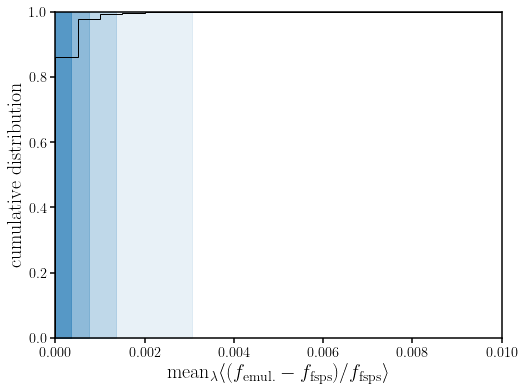

In [13]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for q, a in zip(quant[::-1], [0.1, 0.2, 0.3, 0.5]):
    sub.fill_between([0., q], [0., 0.], [1., 1.], alpha=a, color='C0')
    
_ = sub.hist(mean_frac_dspec, 100, range=(0., 0.05), density=True, histtype='step', cumulative=True, color='k')
sub.set_xlabel(r'${\rm mean}_\lambda \langle (f_{\rm emul.}  - f_{\rm fsps}) / f_{\rm fsps} \rangle$', fontsize=20)
sub.set_xlim(0., 0.01)
sub.set_ylabel('cumulative distribution', fontsize=20)
sub.set_ylim(0., 1.)
fig.savefig('valid_emu_frac_dspec.cdf.pdf', bbox_inches='tight')